# Forward model

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

### Create volume

Text(0.5, 1.0, 'Volume_comp MIP')

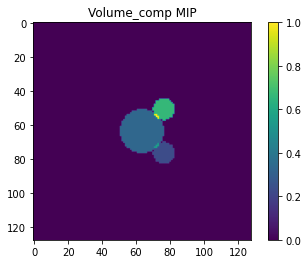

In [4]:
shape = np.array([128,128,128])
dimensions = np.array([1,1,1])

# A volume with components
centres = np.array([[0,0,0], [0.1, 0.1, 0], [0.1, -0.1, 0]])
radii = np.array([0.1, 0.05, 0.05])
intensities = np.array([10,7,20])

v = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False, sigma = 0.01))
mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

0.3634812831878662


Text(0.5, 1.0, 'Vol FFT slice')

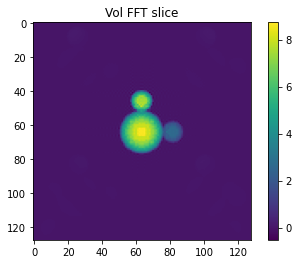

In [11]:
angles = jnp.array([0,0,jnp.pi/4])

start = time.time()
v_slice = project_spatial(v, angles, dimensions,"tri")
print(time.time()-start)


plt.imshow(v_slice); plt.colorbar()
plt.title('Vol FFT slice')

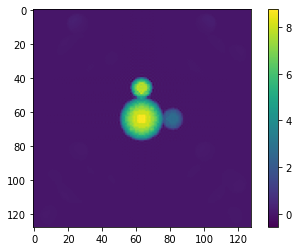

In [12]:
Lx, Ly, Lz = dimensions
Nx, Ny, Nz = shape
dx, dy, dz = dimensions/shape
coords_x = np.linspace(-Lx/2 +dx/2, Lx/2-dx/2, Nx)
coords_y = coords_x

X,Y = np.meshgrid(coords_x, coords_y)

sinc = (np.sinc(X)*np.sinc(Y))

#plt.imshow(sinc)
plt.imshow(v_slice/sinc); plt.colorbar()

In [13]:
@jax.jit
def slice_func(angles):
    return project_spatial(v, angles, dimensions)

@jax.jit
def slice_func_array(angles):
    return jnp.apply_along_axis(slice_func, 1, angles)

In [16]:
angles = jnp.array([np.pi,np.pi/3*2,np.pi/4])

start = time.time()
s1 = slice_func(angles)
print(time.time()-start)

start = time.time()
s2 = slice_func_array(jnp.array([angles]))
print(time.time()-start)

0.032134056091308594
0.03170204162597656


In [19]:
angles_true = jnp.array(np.random.rand(100,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(angles_true)
print(time.time()-start)

print(angles_true.shape)
print(imgs.shape)

0.13824200630187988
(100, 3)
(100, 128, 128)


In [20]:
@jax.jit
def loss_func(a, img):
    return 1/(2* 16641) * jnp.sum((slice_func(a) - img)**2)

@jax.jit 
def loss_func_array(a, imgs):
    return jax.vmap(loss_func, in_axes = (0,0))(a, imgs)

@jax.jit
def dloss_array(a, imgs):
    return jax.vmap(jax.grad(loss_func))(a, imgs)


In [23]:
start = time.time()
l = loss_func_array(angles_true, imgs)
print(time.time()-start)
print(jnp.max(jnp.abs(l)))

0.10242700576782227
0.0


In [24]:
start = time.time()
dl = dloss_array(angles_true, imgs)
print(time.time()-start)
print(jnp.sum(jnp.abs(dl)))

0.21580910682678223
0.0


In [26]:
#a0 = jnp.array(np.random.rand(100,3))*jnp.pi*2
a0 = jnp.array(angles_true + 0.1 * np.random.randn(100,3))
alpha = 0.1
a = a0
iters = 20
for i in range(iters):
    #if np.mod(i,100) == 0:
        #print(i)
    print(str(i) + ": loss = " + str(jnp.mean(loss_func_array(a, imgs))))

    a = a - alpha * dloss_array(a, imgs)

0: loss = 0.03498735
1: loss = 0.020029044
2: loss = 0.01166081
3: loss = 0.007265341
4: loss = 0.005082513
5: loss = 0.0039509237
6: loss = 0.0032475272
7: loss = 0.0027697422
8: loss = 0.0024216368
9: loss = 0.0021426969
10: loss = 0.0019156574
11: loss = 0.0017295226
12: loss = 0.0015726541
13: loss = 0.0014379617
14: loss = 0.0013177576
15: loss = 0.0012093812
16: loss = 0.0011105038
17: loss = 0.0010200624
18: loss = 0.000936987
19: loss = 0.0008609594


In [27]:
jnp.mean(a - jnp.array(angles_true))

DeviceArray(0.00241709, dtype=float32)

## Nearest neighbour interpolation

0.31788015365600586


Text(0.5, 1.0, 'NN')

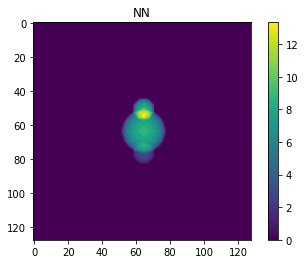

In [29]:
angles = jnp.array([0,np.pi/2,jnp.pi/1000])

start = time.time()
slice_nn = project_spatial(v, angles, dimensions, "nn")
print(time.time()-start)


plt.imshow(slice_nn); plt.colorbar()
plt.title("NN")